In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
pio.templates.default = "plotly_white"


from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer


from qiskit import QuantumCircuit, Aer, transpile, assemble, execute
from qiskit.utils import QuantumInstance
from qiskit.circuit.library import EfficientSU2
from qiskit.algorithms import VQE
from qiskit.algorithms.optimizers import SLSQP
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score



In [2]:
path = 'dos_data_attck.csv'

# **Funções Utils**

In [3]:
def plot_distribution(datas):
  fig = px.bar(
      datas.groupby('Label').size().reset_index(name='Count'),
      y='Label',
      x='Count',
      orientation='h',
      color_discrete_sequence=px.colors.qualitative.Dark2
  )

  fig.update_layout(
      title={
          'text': '<b>Distribuição de Labels</b>',
          'x': 0.5,  # Centralizar o título horizontalmente
          'xanchor': 'center',
          'yanchor': 'top'
      },
      showlegend=False,
      xaxis_title='Quantidade',
      yaxis_title='Label'
  )

  fig.update_yaxes(
      showgrid=False,
      showline=True,
      linewidth=2,
      linecolor='black'
  )
  fig.update_xaxes(
      showgrid=False,
      showline=True,
      linewidth=2,
      linecolor='black'
  )
  fig.show()

In [4]:
def dataset_transform(path, drop_colunms=['Timestamp', 'Can_Interface', 'CAN_ID'],
                      classify_to_binary=False, escalation=False):
  scaler = StandardScaler()  # Instancia o StandardScaler
  columns = ['Timestamp', 'Can_Interface', 'CAN_ID', 'Message', 'Label']
  datas = pd.read_csv(path, sep = ' ', names=columns, engine='python')
  datas = datas.drop(drop_colunms, axis=1)

  # Substituir 'benign' por 0 e outras labels por 1
  if classify_to_binary:
      datas['Label'] = datas['Label'].apply(lambda x: 0 if x == 'benign' else 1)


  # Completar as mensagens com zeros à direita se forem menores que 16 caracteres (8 bytes)
  datas['Message'] = datas['Message'].apply(lambda x: x.ljust(16, '0') if len(x) < 16 else x)

  # Converter cada byte de cada mensagem CAN para seu valor decimal
  data_array = datas.iloc[:,0].values

  tam = len(datas.columns)
  target = datas.iloc[:,(tam-1)].values

  data_transform = []
  for data in data_array:
      numeric_values = [int(data[i:i+2], 16) for i in range(0, len(data), 2)]
      data_transform.append(numeric_values)

  if escalation:
      data_transform = scaler.fit_transform(data_transform)  # Aplica o fit_transform aos valores do DataFrame

  data_transform = np.array(data_transform)
  return datas, data_transform, target

In [8]:
def angle_embedding(data):
    """
    Converte os dados em ângulos de rotação e cria um circuito quântico.
    """
    n_samples, n_features = data.shape
    circuit = QuantumCircuit(n_features)  # Cada feature em um qubit

    # Aplica a rotação Ry para cada feature
    for i in range(n_features):
        # Normaliza para o intervalo [0, pi]
        theta = np.interp(data[:, i], (data[:, i].min(), data[:, i].max()), (0, np.pi))
        circuit.ry(theta[0], i)  # Exemplo com uma amostra

    return circuit

# **Define train and test split**

In [9]:
datas, data_transform, target = dataset_transform(path,  classify_to_binary=True, escalation=True)

In [10]:
x_train, x_test, y_train, y_test = train_test_split(data_transform, target, test_size = 0.3, random_state = 42)

In [7]:
data_transform

array([[-0.37590327, -0.22233327,  1.29541378, ...,  2.09601475,
         2.09601475,  2.09601475],
       [ 2.7864091 ,  4.69311574,  2.76380448, ..., -0.47709588,
        -0.47709588, -0.47709588],
       [-0.37590327, -0.22233327,  1.29541378, ...,  2.09601475,
         2.09601475,  2.09601475],
       ...,
       [-0.40090179, -0.24168543, -0.52075366, ..., -0.47709588,
        -0.47709588, -0.47709588],
       [-0.40090179, -0.24168543, -0.52075366, ..., -0.47709588,
        -0.47709588, -0.47709588],
       [-0.40090179, -0.24168543, -0.52075366, ..., -0.47709588,
        -0.47709588, -0.47709588]])

In [11]:

# Aplicar Angle Embedding separadamente
train_circuit = angle_embedding(x_train)
test_circuit = angle_embedding(x_test)

# Exibe o circuito de treino
print(train_circuit.draw('text'))

     ┌───────┐
q_0: ┤ Ry(0) ├
     ├───────┤
q_1: ┤ Ry(0) ├
     ├───────┤
q_2: ┤ Ry(0) ├
     ├───────┤
q_3: ┤ Ry(0) ├
     ├───────┤
q_4: ┤ Ry(0) ├
     ├───────┤
q_5: ┤ Ry(0) ├
     ├───────┤
q_6: ┤ Ry(0) ├
     ├───────┤
q_7: ┤ Ry(0) ├
     └───────┘


10-Fold Progress:   0%|          | 0/10 [00:00<?, ?it/s]

10-Fold Progress:  10%|█         | 1/10 [00:03<00:34,  3.85s/it]

Fold 1: Accuracy = 0.5004, Loss = 18.0074


10-Fold Progress:  20%|██        | 2/10 [00:06<00:25,  3.19s/it]

Fold 2: Accuracy = 0.4978, Loss = 18.1011


10-Fold Progress:  30%|███       | 3/10 [00:08<00:17,  2.54s/it]

Fold 3: Accuracy = 0.5011, Loss = 17.9817


10-Fold Progress:  40%|████      | 4/10 [00:10<00:14,  2.46s/it]

Fold 4: Accuracy = 0.4991, Loss = 18.0558


10-Fold Progress:  50%|█████     | 5/10 [00:14<00:15,  3.07s/it]

Fold 5: Accuracy = 0.4992, Loss = 18.0496


10-Fold Progress:  60%|██████    | 6/10 [00:17<00:12,  3.04s/it]

Fold 6: Accuracy = 0.4967, Loss = 18.1423


10-Fold Progress:  70%|███████   | 7/10 [00:19<00:07,  2.56s/it]

Fold 7: Accuracy = 0.4999, Loss = 18.0239


10-Fold Progress:  80%|████████  | 8/10 [00:22<00:05,  2.61s/it]

Fold 8: Accuracy = 0.4997, Loss = 18.0332


10-Fold Progress:  90%|█████████ | 9/10 [00:24<00:02,  2.64s/it]

Fold 9: Accuracy = 0.5030, Loss = 17.9147


10-Fold Progress: 100%|██████████| 10/10 [00:26<00:00,  2.61s/it]

Fold 10: Accuracy = 0.4995, Loss = 18.0393

Final Results - Mean Accuracy: 0.4996, Mean Loss: 18.0349


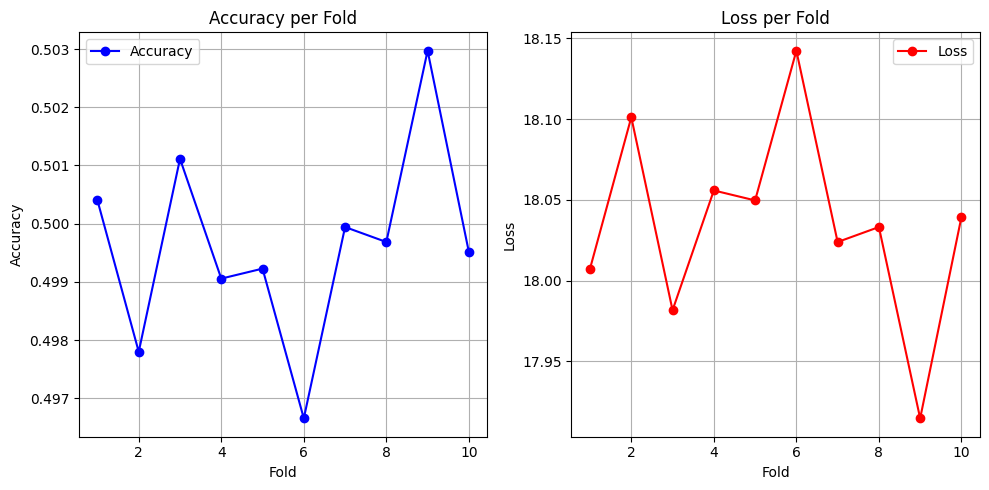

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import Aer
from qiskit.circuit.library import EfficientSU2
from qiskit.opflow import PauliSumOp
from qiskit.algorithms import VQE
from qiskit.algorithms.optimizers import SLSQP
from qiskit.utils import QuantumInstance
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, log_loss
from tqdm import tqdm

# Função para criar o CQV
def create_circuit(num_qubits, ansatz_type='efficient'):
    if ansatz_type == 'efficient':
        ansatz = EfficientSU2(num_qubits, entanglement='linear')
    else:
        raise ValueError("Unsupported ansatz type.")
    return ansatz

# Função para treinar o CQV
def train_circuit(X_train, y_train, num_qubits):
    ansatz = create_circuit(num_qubits)
    operator = PauliSumOp.from_list([("Z" * num_qubits, 1.0)])  # Exemplo de operador ZZZ
    optimizer = SLSQP(maxiter=100)  # Otimizador SLSQP
    backend = Aer.get_backend('statevector_simulator')

    vqe = VQE(ansatz, optimizer, quantum_instance=QuantumInstance(backend))
    vqe_result = vqe.compute_minimum_eigenvalue(operator)

    # Retornar o estado mínimo como saída do modelo
    return vqe_result

# Função para classificar instâncias
def classify_circuit(vqe_result, X_test):
    # Simulação simplificada: retorna previsões aleatórias (0 ou 1) para demonstrar o processo
    return np.random.randint(2, size=len(X_test))

# Função para executar 10-fold cross-validation
def run_experiment(X, y, num_qubits):
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    accuracies = []
    losses = []

    # Loop pelos folds com barra de progresso
    for fold, (train_index, test_index) in enumerate(tqdm(skf.split(X, y), total=10, desc='10-Fold Progress')):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Treinamento do CQV
        vqe_result = train_circuit(X_train, y_train, num_qubits)

        # Classificação e avaliação
        predictions = classify_circuit(vqe_result, X_test)
        accuracy = accuracy_score(y_test, predictions)
        accuracies.append(accuracy)

        # Calcular loss (usando log_loss para classificação binária)
        loss = log_loss(y_test, predictions, labels=[0, 1])
        losses.append(loss)

        print(f"Fold {fold + 1}: Accuracy = {accuracy:.4f}, Loss = {loss:.4f}")

    # Relatório final de resultados
    mean_accuracy = np.mean(accuracies)
    mean_loss = np.mean(losses)
    print(f'\nFinal Results - Mean Accuracy: {mean_accuracy:.4f}, Mean Loss: {mean_loss:.4f}')

    # Plot dos gráficos de acurácia e loss por fold
    plot_results(accuracies, losses)

# Função para plotar gráficos de acurácia e loss por fold
def plot_results(accuracies, losses):
    folds = np.arange(1, 11)

    # Gráfico de acurácia por fold
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(folds, accuracies, marker='o', linestyle='-', color='blue', label='Accuracy')
    plt.xlabel('Fold')
    plt.ylabel('Accuracy')
    plt.title('Accuracy per Fold')
    plt.legend()
    plt.grid(True)

    # Gráfico de loss por fold
    plt.subplot(1, 2, 2)
    plt.plot(folds, losses, marker='o', linestyle='-', color='red', label='Loss')
    plt.xlabel('Fold')
    plt.ylabel('Loss')
    plt.title('Loss per Fold')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Executar o experimento
run_experiment(x_train, y_train, num_qubits=3)  # Exemplo com 3 qubits
